In [1]:
import xarray as xr
import numpy as np
import tensorflow as tf
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path
from tensorflow.keras.datasets import mnist
from flows import Flow
from flows.affine import Planar
from flows.sylvester import TriangularSylvester
from models.vae import GatedConvVAE
from cartopy.util import add_cyclic_point
from urllib.request import urlretrieve

In [2]:
# The NetCDF file is about 228 MB
CCSM4_NC_FILENAME = 'data/cmip5_rcp26_CCSM4.nc'
if not os.path.exists(CCSM4_NC_FILENAME):
    print('Downloading CMIP5 CCSM4 data ...')
    os.makedirs('data/')
    urlretrieve('https://storage.googleapis.com/cmip5-monthly/rcp26/CCSM4/rcp26_CCSM4_grid.nc', CCSM4_NC_FILENAME)
    print('Done')
else:
    print('Found existing data file: {}'.format(CCSM4_NC_FILENAME))

Found existing data file: data/cmip5_rcp26_CCSM4.nc


In [3]:
ccsm4_ds = xr.load_dataset(CCSM4_NC_FILENAME)
# remove dicontinuity in longitude
_, lons = add_cyclic_point(ccsm4_ds.lon, ccsm4_ds.lon)
ccsm4_ds = ccsm4_ds.reindex(time=ccsm4_ds.time, lat=ccsm4_ds.lat, lon=np.linspace(lons[0], lons[-1], ccsm4_ds.lon.size), method='nearest')
print(ccsm4_ds)
ccsm4_train = ccsm4_ds['tas'][:-12*80].expand_dims('chan', axis=-1)
ccsm4_test = ccsm4_ds['tas'][-12*80:].expand_dims('chan', axis=-1)
print(ccsm4_train.time)
print(ccsm4_test.time)

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 2880)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 2873 2874 2875 2876 2877 2878 2879
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.767 6.285 8.802 ... 353.7 356.2 358.7 361.2
    months   (time) object 'Jan' 'Feb' 'Mar' 'Apr' ... 'Sep' 'Oct' 'Nov' 'Dec'
    years    (time) int32 1861 1861 1861 1861 1861 ... 2100 2100 2100 2100 2100
Data variables:
    tas      (time, lat, lon) float64 -1.763 -1.999 -1.91 ... 5.415 5.4 5.4
<xarray.DataArray 'time' (time: 1920)>
array([   0,    1,    2, ..., 1917, 1918, 1919])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 1913 1914 1915 1916 1917 1918 1919
    months   (time) object 'Jan' 'Feb' 'Mar' 'Apr' ... 'Sep' 'Oct' 'Nov' 'Dec'
    years    (time) int32 1861 1861 1861 1861 1861 ... 2020 2020 2020 2020 2020
<xarray.DataArray 'time' (time: 960)>
array([1920, 1921, 1922, ..., 2877, 2878, 2879])
Coordinate

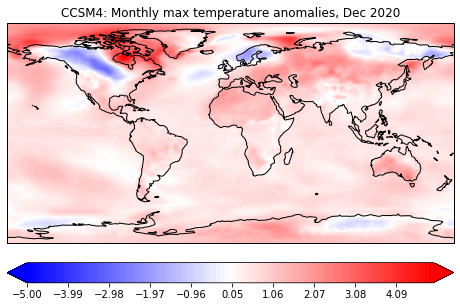

In [15]:
def plot_geo_heatmap(X, lats, lons, cmap="viridis", figsize=(8,6), title='', min_max=None,  bins=100, gridlines=False):
    import cartopy.crs as ccrs
    X = X.squeeze()
    assert len(X.shape) == 2
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=proj)
    ax.set_extent([lons[0], lons[-1], lats[0], lats[-1]], proj)
    min_val, max_val = (min_max[0], min_max[1]) if min_max is not None else (np.nanmin(X), np.nanmax(X))
    breaks = np.linspace(min_val-1.0E-5, max_val+1.0E-5, bins)
    cs = ax.contourf(lons, lats, X, breaks, cmap=cmap, transform=proj, extend='both')
    cbar = plt.colorbar(cs, ax=ax, orientation='horizontal', pad=0.06)
    ax.coastlines()
    if gridlines:
        ax.gridlines(crs=proj, draw_labels=True)
        ax.set_title(title, y=1.09)
    else:
        ax.set_title(title)
        
def plot_geo_heatmap_factory(rows, cols, figsize=(6,4), cmap='viridis', min_max=None, bins=100, gridlines=False,
                             wspace=0.05, hspace=0.05, cbar_per_subplot=False, cbar_orientation='horizontal'):
    import cartopy.crs as ccrs
    proj = ccrs.PlateCarree()
    fig, axarr = plt.subplots(rows, cols, figsize=(cols*figsize[0], rows*figsize[1]), subplot_kw={'projection': proj})
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    def plot_next(ax, X, lats, lons, cmap=cmap, title='', bins=bins, min_max=min_max, gridlines=gridlines):
        X = X.squeeze()
        assert len(X.shape) == 2
        ax.set_extent([lons[0], lons[-1], lats[0], lats[-1]], proj)
        min_val, max_val = (min_max[0]-1.0E-15, min_max[1]+1.0E-15) if min_max is not None else (np.nanmin(X), np.nanmax(X))
        breaks = np.linspace(min_val-1.0E-15, max_val+1.0E-15, bins+1)
        cs = ax.contourf(lons, lats, X, breaks, cmap=cmap, transform=proj, extend='both')
        if cbar_per_subplot:
            plt.colorbar(cs, ax=ax, orientation=cbar_orientation, pad=0.03)
        ax.coastlines()
        if gridlines:
            ax.gridlines(crs=proj, draw_labels=True)
            ax.set_title(title, y=1.09)
        else:
            ax.set_title(title)
        return cs
    return fig, axarr, plot_next


t = ccsm4_train.time[-1]
plot_geo_heatmap(ccsm4_ds['tas'][t], ccsm4_ds.lat, ccsm4_ds.lon, figsize=(8,6), cmap='bwr', min_max=(-5,5))
plt.title('CCSM4: Monthly max temperature anomalies, {} {}'.format(ccsm4_ds.months[t].values, ccsm4_ds.years[t].values))
plt.show()

In [5]:
def train_vae(x_train, x_test, flow=None, z_size=32, hidden_units=32, n_epochs=10):
    def bias(y_true, y_pred):
        import tensorflow.keras.backend as K
        return K.mean(y_pred - y_true, axis=-1)
    beta_update = lambda i, beta: (i+1) / n_epochs
    vae = GatedConvVAE(x_train.shape[1], x_train.shape[2], flow, z_size=z_size, hidden_units=hidden_units, num_downsamples=2,
                       output_activation='linear', loss='mse', beta_update_fn=beta_update, metrics=[bias])
    vae.fit(x_train, x_train, epochs=n_epochs, batch_size=32, validation_data=(x_test, x_test))
    return vae

### Vanilla VAE

In [8]:
vae = train_vae(ccsm4_train.values, ccsm4_test.values, n_epochs=20)

Train on 1920 samples, validate on 960 samples
Epoch 1/20
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.9178 - bias: 0.1217 - val_loss: 0.7267 - val_bias: -0.1140
Epoch 2/20
1920/1920 [==============================] - 2s 1ms/sample - loss: 0.4342 - bias: 0.0044 - val_loss: 0.4694 - val_bias: -0.0134
Epoch 3/20
1920/1920 [==============================] - 2s 1ms/sample - loss: 0.3480 - bias: 0.0027 - val_loss: 0.4014 - val_bias: -0.0851
Epoch 4/20
1920/1920 [==============================] - 2s 1ms/sample - loss: 0.3175 - bias: 0.0049 - val_loss: 0.3766 - val_bias: -0.0063
Epoch 5/20
1920/1920 [==============================] - 2s 1ms/sample - loss: 0.2956 - bias: 0.0015 - val_loss: 0.3484 - val_bias: 0.0149
Epoch 6/20
1920/1920 [==============================] - 2s 1ms/sample - loss: 0.2804 - bias: 0.0031 - val_loss: 0.3303 - val_bias: -0.0215
Epoch 7/20
1920/1920 [==============================] - 2s 1ms/sample - loss: 0.2762 - bias: 0.0013 - val_loss: 0.3352 -

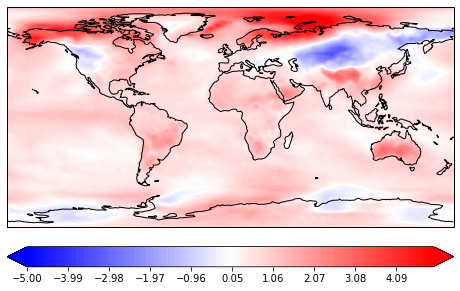

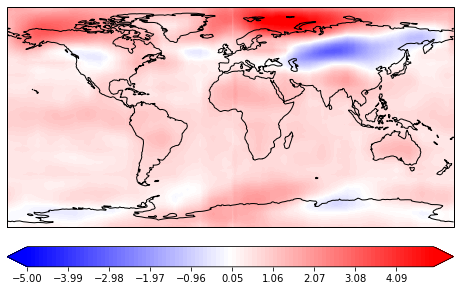

In [19]:
x_pred_vae = vae.predict(ccsm4_test.values)
plot_geo_heatmap(ccsm4_test[10], ccsm4_ds.lat, ccsm4_ds.lon, figsize=(8,6), cmap='bwr', min_max=(-5,5))
plot_geo_heatmap(x_pred[10], ccsm4_ds.lat, ccsm4_ds.lon, figsize=(8,6), cmap='bwr', min_max=(-5,5))

### Planar VAE

In [10]:
n_flows = 8
planar_flow = Flow.uniform(n_flows, lambda i: Planar())
planar_vae = train_vae(ccsm4_train.values, ccsm4_test.values, planar_flow, n_epochs=20)

Train on 1920 samples, validate on 960 samples
Epoch 1/20
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.9451 - bias: 0.1171 - val_loss: 0.8180 - val_bias: 0.0430
Epoch 2/20
1920/1920 [==============================] - 3s 1ms/sample - loss: 0.4475 - bias: 0.0045 - val_loss: 0.5038 - val_bias: -0.0677
Epoch 3/20
1920/1920 [==============================] - 3s 1ms/sample - loss: 0.3667 - bias: 0.0035 - val_loss: 0.5226 - val_bias: -0.3298
Epoch 4/20
1920/1920 [==============================] - 3s 1ms/sample - loss: 0.3317 - bias: 0.0028 - val_loss: 0.4049 - val_bias: -0.0815
Epoch 5/20
1920/1920 [==============================] - 2s 1ms/sample - loss: 0.3092 - bias: 0.0011 - val_loss: 0.3806 - val_bias: -0.0876
Epoch 6/20
1920/1920 [==============================] - 3s 1ms/sample - loss: 0.2983 - bias: 0.0021 - val_loss: 0.3691 - val_bias: -0.1112
Epoch 7/20
1920/1920 [==============================] - 3s 1ms/sample - loss: 0.2916 - bias: 0.0019 - val_loss: 0.3650 -

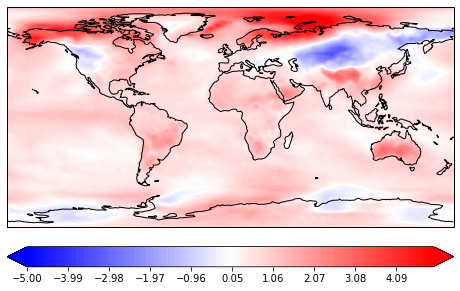

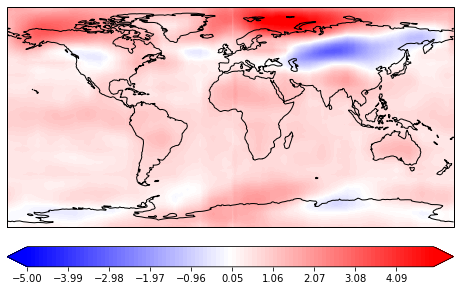

In [18]:
x_pred_planar = planar_vae.predict(ccsm4_test.values)
plot_geo_heatmap(ccsm4_test[10], ccsm4_ds.lat, ccsm4_ds.lon, figsize=(8,6), cmap='bwr', min_max=(-5,5))
plot_geo_heatmap(x_pred[10], ccsm4_ds.lat, ccsm4_ds.lon, figsize=(8,6), cmap='bwr', min_max=(-5,5))

### Triangular Sylvester VAE

In [6]:
n_flows = 8
tsnf_flow = Flow.uniform(n_flows, lambda i: TriangularSylvester(flip_z = i % 2 != 0))
tsnf_vae = train_vae(ccsm4_train.values, ccsm4_test.values, tsnf_flow, n_epochs=20)

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(values, collections.Sequence):


Train on 1920 samples, validate on 960 samples
Epoch 1/20
1920/1920 [==============================] - 15s 8ms/sample - loss: 1.0069 - bias: 0.1179 - val_loss: 1.1838 - val_bias: -0.4339
Epoch 2/20
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.5181 - bias: 9.7119e-04 - val_loss: 0.6469 - val_bias: -0.3116
Epoch 3/20
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.3820 - bias: 0.0029 - val_loss: 0.4373 - val_bias: -0.0143
Epoch 4/20
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.3266 - bias: 0.0020 - val_loss: 0.4048 - val_bias: -0.1563
Epoch 5/20
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.2952 - bias: 0.0020 - val_loss: 0.3733 - val_bias: -0.1293
Epoch 6/20
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.2835 - bias: 0.0015 - val_loss: 0.3476 - val_bias: -0.1288
Epoch 7/20
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.2723 - bias: 0.0019 - val_loss: 0.

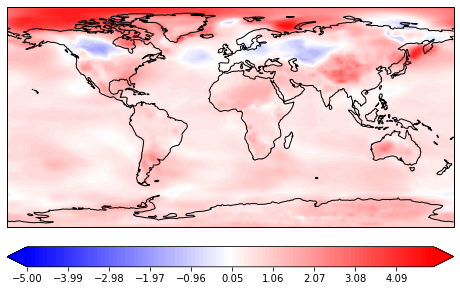

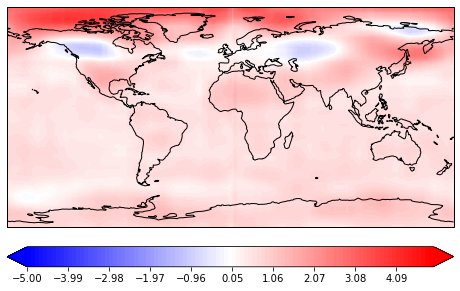

In [17]:
x_pred_tsnf = tsnf_vae.predict(ccsm4_test.values)
plot_geo_heatmap(ccsm4_test[0], ccsm4_ds.lat, ccsm4_ds.lon, figsize=(8,6), cmap='bwr', min_max=(-5,5))
plot_geo_heatmap(x_pred[0], ccsm4_ds.lat, ccsm4_ds.lon, figsize=(8,6), cmap='bwr', min_max=(-5,5))

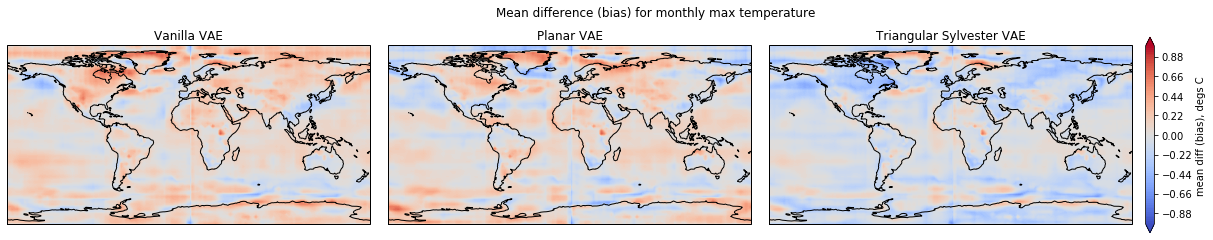

In [34]:
t = -1 #last timestep
fig, axs, plot_fn = plot_geo_heatmap_factory(1,3,cmap='coolwarm', min_max=(-1,1), figsize=(8,6))
plot_fn(axs[0], (x_pred_vae - ccsm4_test).mean(dim='time'), ccsm4_test.lat, ccsm4_test.lon, title='Vanilla VAE',)
plot_fn(axs[1], (x_pred_planar - ccsm4_test).mean(dim='time'), ccsm4_test.lat, ccsm4_test.lon, title='Planar VAE')
cs = plot_fn(axs[2], (x_pred_tsnf - ccsm4_test).mean(dim='time'), ccsm4_test.lat, ccsm4_test.lon, title='Triangular Sylvester VAE')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('mean diff (bias), degs C')
plt.suptitle('Mean difference (bias) for monthly max temperature', y=0.80)
plt.show()